- creating the data pipeline with tf.data
- Preprocessing word sequences (varaible input sequence length) using padding
- Using tf.nn.embedding_lookup

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string
%matplotlib inline

slim = tf.contrib.slim
print(tf.__version__)

Instructions for updating:
Use the retry module or similar alternatives.
1.7.0


In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1., 0.], [0., 1.], [1., 0.], [1., 0.], [0., 1.], [1., 0.]]

In [3]:
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

In [4]:
char_space = string.ascii_lowercase
char_space = char_space + ' ' + '*'
char_space

'abcdefghijklmnopqrstuvwxyz *'

In [5]:
char_dic = {char : idx for idx, char in enumerate(char_space)}
print(char_dic)

{'k': 10, 's': 18, ' ': 26, 'h': 7, 'o': 14, 'p': 15, 'w': 22, 'j': 9, 'b': 1, 'f': 5, 'i': 8, '*': 27, 'm': 12, 'z': 25, 'e': 4, 'r': 17, 'n': 13, 'x': 23, 'g': 6, 'v': 21, 'd': 3, 'c': 2, 'a': 0, 'l': 11, 't': 19, 'u': 20, 'q': 16, 'y': 24}


In [6]:
print(char_dic.get('x'))

23


In [7]:
def pad_seq(sequences, max_len, dic):
    seq_len, seq_indices = [], []
    # sequence에 있는 하나의 단어당
    for seq in sequences:
        # 단어 seq에 해당하는 길이
        seq_len.append(len(seq))
        # 각 단어의 해당하는 character의 id 값에 대한 list를 얻어온다.
        seq_idx = [dic.get(char) for char in seq]
        # max_len보다 길이가 작으면 남은 칸은 *로 채운다.
        seq_idx += (max_len - len(seq_idx)) * [dic.get('*')]
        # seq_indices에 처리된 seq단어에 대한 ids값을 append한다.
        seq_indices.append(seq_idx)
    return seq_len, seq_indices

In [8]:
max_length = 10
X_length, X_indices  =pad_seq(sequences=words, max_len=max_length, dic=char_dic)

In [9]:
print(X_length)
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


In [10]:
print(X_indices)

[[6, 14, 14, 3, 27, 27, 27, 27, 27, 27], [1, 0, 3, 27, 27, 27, 27, 27, 27, 27], [0, 12, 0, 25, 8, 13, 6, 27, 27, 27], [18, 14, 26, 6, 14, 14, 3, 27, 27, 27], [1, 20, 11, 11, 26, 18, 7, 8, 19, 27], [0, 22, 4, 18, 14, 12, 4, 27, 27, 27]]


In [11]:
len(char_dic)

28

In [12]:
class CharRNN:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dim, dic):
        
        with tf.variable_scope('input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot,
                                           trainable=False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            
        #RNN cell
        with tf.variable_scope('rnn_cell'):
            rnn_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_dim,activation=tf.nn.tanh)
            #tf.contrib.rnn.BasicRNNCell(num_units=hidden_dim,activation=tf.nn.tanh)
            _, state = tf.nn.dynamic_rnn(cell=rnn_cell,inputs=self._X_batch,
                                         sequence_length=self._X_length, dtype=tf.float32)
            
        with tf.variable_scope('output_layer'):
            self._score = slim.fully_connected(inputs=state,num_outputs=n_of_classes,activation_fn=None)
            
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input=self._score, axis=-1, output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices):
        feed_prediction = {self._X_length : X_length, self._X_indices: X_indices}
        return sess.run(self._prediction, feed_dict=feed_prediction)
        

In [13]:
class CharLSTM:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dim, dic):
        
        with tf.variable_scope('input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot,
                                           trainable=False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            
        with tf.variable_scope('lstm_cell'):
            lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_dim, activation=tf.nn.tanh)
            self.outputs, self.states = tf.nn.dynamic_rnn(cell=lstm_cell,inputs=self._X_batch,
                                               sequence_length=self._X_length, dtype=tf.float32)
            
        with tf.variable_scope('output_layer'):
            self._score = slim.fully_connected(inputs=self.states.h, num_outputs=n_of_classes,
                                              activation_fn=None)
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input=self._score, axis=-1, output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices):
        feed_prediction = {self._X_length: X_length, self._X_indices:X_indices}
        return sess.run(self._prediction, feed_dict=feed_prediction)

```python
char_rnn.outputs
<tf.Tensor 'lstm_cell/rnn/transpose_1:0' shape=(?, 10, 16) dtype=float32>

char_rnn.states
LSTMStateTuple(c=<tf.Tensor 'lstm_cell/rnn/while/Exit_3:0' shape=(?, 16) dtype=float32>, h=<tf.Tensor 'lstm_cell/rnn/while/Exit_4:0' shape=(?, 16) dtype=float32>)
```

In [14]:
class CharGRU:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dim, dic):
        
        with tf.variable_scope('input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot, 
                                            trainable=False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            
        with tf.variable_scope('gru_cell'):
            self.gru_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim,activation=tf.nn.tanh)
            self.output, self.state = tf.nn.dynamic_rnn(cell=self.gru_cell, inputs=self._X_batch,
                                                       sequence_length=self._X_length,dtype=tf.float32)
            
        with tf.variable_scope('output_layer'):
            self._score = slim.fully_connected(inputs=self.state,num_outputs=n_of_classes,activation_fn=None)
        
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input=self._score, axis=-1, output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices):
        return sess.run(self._prediction, feed_dict={self._X_length:X_length, self._X_indices:X_indices})

In [15]:
np.shape(X_indices)[0]

6

In [16]:
lr = 0.003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0]/batch_size)
print(total_step)

3


In [18]:
tr_dataset = tf.data.Dataset.from_tensor_slices((X_length, X_indices, y))
tr_dataset = tr_dataset.shuffle(buffer_size=20)
tr_dataset = tr_dataset.batch(batch_size=batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

<BatchDataset shapes: ((?,), (?, 10), (?, 2)), types: (tf.int32, tf.int32, tf.float32)>


In [19]:
X_length_mb, X_indices_mb, y_mb = tr_iterator.get_next()

In [20]:
# char_rnn = CharRNN(X_length=X_length_mb,X_indices=X_indices_mb,y=y_mb,n_of_classes=2,hidden_dim=16,
#                   dic=char_dic)

char_rnn = CharLSTM(X_length=X_length_mb,X_indices=X_indices_mb,y=y_mb,n_of_classes=2,hidden_dim=16,
                   dic=char_dic)

# char_rnn = CharGRU(X_length=X_length_mb,X_indices=X_indices_mb,y=y_mb,n_of_classes=2,hidden_dim=16,
#                    dic=char_dic)

In [22]:
char_rnn.outputs

<tf.Tensor 'lstm_cell/rnn/transpose_1:0' shape=(?, 10, 16) dtype=float32>

In [24]:
char_rnn.states

LSTMStateTuple(c=<tf.Tensor 'lstm_cell/rnn/while/Exit_3:0' shape=(?, 16) dtype=float32>, h=<tf.Tensor 'lstm_cell/rnn/while/Exit_4:0' shape=(?, 16) dtype=float32>)

In [20]:
opt = tf.train.AdamOptimizer(learning_rate=lr)
training_op = opt.minimize(loss=char_rnn.ce_loss)

In [21]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0

    sess.run(tr_iterator.initializer)
    try:
        while True:
            _, tr_loss = sess.run([training_op, char_rnn.ce_loss])
            avg_tr_loss += tr_loss
            tr_step += 1

    except tf.errors.OutOfRangeError:
        pass

    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)

    print('epoch: {:3}, tr_loss: {:.3f}'.format(epoch+1, avg_tr_loss))

epoch:   1, tr_loss: 0.659
epoch:   2, tr_loss: 0.629
epoch:   3, tr_loss: 0.608
epoch:   4, tr_loss: 0.581
epoch:   5, tr_loss: 0.560
epoch:   6, tr_loss: 0.533
epoch:   7, tr_loss: 0.503
epoch:   8, tr_loss: 0.475
epoch:   9, tr_loss: 0.445
epoch:  10, tr_loss: 0.415


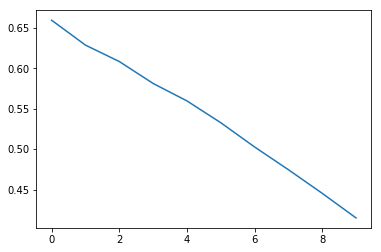

In [22]:
plt.plot(tr_loss_hist, label='train')

In [23]:
yhat = char_rnn.predict(sess=sess, X_length=X_length, X_indices=X_indices)

In [24]:
yhat

array([0, 0, 0, 0, 1, 0])

In [25]:
np.argmax(y, axis=-1)

array([0, 1, 0, 0, 1, 0], dtype=int64)

In [26]:
y

[[1.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0], [1.0, 0.0]]

In [27]:
print('training acc: {:.2%}'.format(np.mean(yhat==np.argmax(y, axis=-1))))

training acc: 83.33%
